In [2]:
import numpy as np
import pandas as pd
import os
import shutil

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import v2
from torchvision import transforms, models

import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
df_total_train = pd.read_csv('./eda/df_total_train_shuffled_v1.csv')
df_total_val = pd.read_csv('./eda/df_total_val_shuffled_v1.csv')
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')

In [4]:
train_X = (df_total_train['img_folder'] + df_total_train['defect_image']).tolist()
train_y = (df_total_train['repairStatus']).tolist()

val_X = (df_total_val['img_folder'] + df_total_val['defect_image']).tolist()
val_y = (df_total_val['repairStatus']).tolist()

test_X = (df_total_test['img_folder'] + df_total_test['defect_image']).tolist()
test_y = (df_total_test['repairStatus']).tolist()

In [5]:
class image(Dataset):

    def __init__(self, X, Y, transform=None):
        self.X = X
        self.y = Y
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
 
        img_path = self.X[idx]
        image = read_image(img_path)

        if image.size()[0] == 1:
            image = image.expand(3,*image.shape[1:])

        if self.transform:
            image = self.transform(image)

        return image, self.y[idx]

In [7]:
resolution = (240, 240)

train_transforms = transforms.Compose([
    transforms.Resize(resolution),
    # transforms.RandomHorizontalFlip(),
    # v2.RandomCrop(size=(224, 224)),
    # v2.RandomResizedCrop(size=(32, 32)),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.equalizer = v2.RandomEqualize(),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    # transforms.ColorJitter(),
    # transforms.ToTensor(),
    # transforms.RandAugment(num_ops = 2, magnitude = 9),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # transforms.RandomErasing(),
])

val_transforms = transforms.Compose([
    transforms.Resize(resolution),
    #transforms.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize(resolution),
    #transforms.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = image(train_X, train_y, train_transforms)
val_dataset = image(val_X, val_y, val_transforms)
test_dataset = image(test_X, test_y, test_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


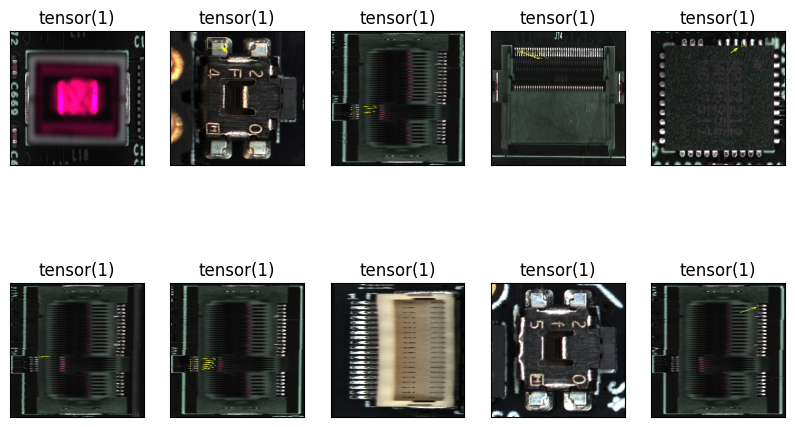

In [8]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

img = images.numpy()
img = img / 2 + 0.5

fig, axes = plt.subplots(2, int(batch_size/2), figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(np.transpose(img[i], (1, 2, 0)))
    ax.set_title(labels[i])

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
device

NVIDIA GeForce RTX 3060 Ti


device(type='cuda', index=0)

In [10]:
def train_model(model, loss, optimizer, num_epochs, device):
    '''
        Обучение модели
    '''
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # на каждой эпохе проходим фазу обучения и валидации
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train() # обучение
            else:
                dataloader = val_dataloader
                model.eval() # валидация

            # метрики потерь и точности
            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):

                    # forward
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    
                    # backward в фазе обучения
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                
                # обновление метрик
                running_loss += loss_value.item()
                if phase == 'train':
                    # running_acc += (preds_class == labels.argmax(dim=1)).float().mean()
                    running_acc += (preds_class == labels).float().mean()
                else:
                    running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
        
    # return model

In [11]:
def accuracy_recall_precision(model, dataloader):
    model.eval()
      
    all_predictions = []
    all_labels = []

    #  computing accuracy
    total_correct = 0
    total_instances = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        all_labels.extend(labels)
        predictions = torch.argmax(model(images), dim=1)
        all_predictions.extend(predictions)
        correct_predictions = sum(predictions==labels).item()
        total_correct+=correct_predictions
        total_instances+=len(images)
    accuracy = round(total_correct/total_instances, 3)

    #  computing recall and precision
    true_positives = 0
    false_negatives = 0
    false_positives = 0
    for idx in range(len(all_predictions)):
        if all_predictions[idx].item()==1 and  all_labels[idx].item()==1:
          true_positives+=1
        elif all_predictions[idx].item()==0 and all_labels[idx].item()==1:
          false_negatives+=1
        elif all_predictions[idx].item()==1 and all_labels[idx].item()==0:
          false_positives+=1
    try:
        recall = round(true_positives/(true_positives + false_negatives), 3)
    except ZeroDivisionError:
        recall = 0.0
    try:
        precision = round(true_positives/(true_positives + false_positives), 3)
    except ZeroDivisionError:
        precision = 0.0
    
    return accuracy, recall, precision

In [12]:
# предобученная модель efficientnet_v2_l
model = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')

# перекладываем модель на device (если есть gpu)
model = model.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0.00001, verbose=True)

num_epochs = 10

In [13]:
train_model(model, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/9:


100%|██████████| 4911/4911 [48:13<00:00,  1.70it/s] 

train Loss: 0.0471 Acc: 0.9920



100%|██████████| 655/655 [03:43<00:00,  2.93it/s]

val Loss: 0.0361 Acc: 0.9947
Epoch 1/9:



100%|██████████| 4911/4911 [22:34<00:00,  3.62it/s]

train Loss: 0.0186 Acc: 0.9947



100%|██████████| 655/655 [01:01<00:00, 10.62it/s]

val Loss: 0.0235 Acc: 0.9937
Epoch 2/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0146 Acc: 0.9959



100%|██████████| 655/655 [01:01<00:00, 10.64it/s]

val Loss: 0.0326 Acc: 0.9940
Epoch 3/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.80it/s]

train Loss: 0.0113 Acc: 0.9968



100%|██████████| 655/655 [01:01<00:00, 10.67it/s]

val Loss: 0.0226 Acc: 0.9948
Epoch 4/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0099 Acc: 0.9975



100%|██████████| 655/655 [01:01<00:00, 10.68it/s]

val Loss: 0.0219 Acc: 0.9936
Epoch 5/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0087 Acc: 0.9974



100%|██████████| 655/655 [01:01<00:00, 10.68it/s]

val Loss: 0.0297 Acc: 0.9947
Epoch 6/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0079 Acc: 0.9979



100%|██████████| 655/655 [01:01<00:00, 10.71it/s]

val Loss: 0.0287 Acc: 0.9960
Epoch 7/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0074 Acc: 0.9982



100%|██████████| 655/655 [01:01<00:00, 10.67it/s]

val Loss: 0.0247 Acc: 0.9950
Epoch 8/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0082 Acc: 0.9975



100%|██████████| 655/655 [01:01<00:00, 10.65it/s]

val Loss: 0.0244 Acc: 0.9953
Epoch 9/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0077 Acc: 0.9979



100%|██████████| 655/655 [01:01<00:00, 10.69it/s]

val Loss: 0.0255 Acc: 0.9951


In [14]:
torch.save(model, "./EfV2L_noaug_10e_base_shfld_v1.pt")

In [12]:
# загружаем модель
model_path = '.'
model = torch.load(f'{model_path}/EfV2L_noaug_10e_base_shfld_v1.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
accuracy_recall_precision(model, train_dataloader)

  0%|          | 0/4911 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 4911/4911 [32:55<00:00,  2.49it/s]


(0.999, 1.0, 1.0)

In [15]:
accuracy_recall_precision(model, test_dataloader)

100%|██████████| 982/982 [05:00<00:00,  3.27it/s]


(0.996, 0.998, 0.998)

In [16]:
correct = 0
total = 0
test_res = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        preds = model(inputs)
        preds_class = preds.argmax(dim=1)

        total += labels.size(0)
        correct += (preds_class == labels).sum().item()

        test_res.extend(preds_class.tolist())

print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

100%|██████████| 982/982 [01:34<00:00, 10.35it/s]

Accuracy of the network on the 9820 test images: 99.64358452138492 %


In [17]:
len(test_res), list(zip(*np.unique(test_res, return_counts=True)))

(9820, [(0, 69), (1, 9751)])

In [19]:
df_total_test['modelPredict'] = test_res
df_total_test.head(5)

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder,modelPredict
0,MBDX86742001B_T,Y1MTB44BYF012,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-04-11-45-38,Billboard,Larisa_VVTS08,1,1:c92,GRM188C80G106KE47D,NaN,"['Billboard', 'BadJoint', 'RowOffset', 'Coplan...",E_4799_1-c92.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...,1
1,MPLSAS731005D_T,Y0PYD44FWN05W,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-06-15-07-57,BadJoint,Larisa_VVTS08,1,j43,0787280002,NaN,['BadJoint'],E_434_j43.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...,1
2,MPLSAS731005D_T,Y0PYD44LFR03T,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-04-21-47-04,BadJoint,Svetlana_VVTS08,1,j62,0787280002,NaN,['BadJoint'],E_5001_j62.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...,1
3,RSRPCI782009B_B,Y1E3B44GAU0PC,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-04-09-45-36,RowOffset,Larisa_VVTS08,1,1:u10,PI3DBS12212AXUAEX,NaN,['RowOffset'],E_4781_1-u10.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...,1
4,MPLSAS731005D_T,Y0PYD444W706O,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-13-15-32-23,BadJoint,Larisa_VVTS08,1,j61,0787280002,NaN,['BadJoint'],E_1849_j61.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...,1


In [20]:
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_F = df_total_test.loc[df_total_test['modelPredict'] == 0]


df_total_test_TP = df_total_test_T.loc[df_total_test_T['modelPredict'] == df_total_test_T['repairStatus']]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]
df_total_test_TN = df_total_test_F.loc[df_total_test_F['modelPredict'] == df_total_test_F['repairStatus']]
df_total_test_FN = df_total_test_F.loc[df_total_test_F['modelPredict'] != df_total_test_F['repairStatus']]

In [21]:
df_total_test_FP.count(), df_total_test_FN.count(), df_total_test_TN.count()

(assemblyRevision    18
 serialNumber        18
 testerName          18
 type                18
 dataFolderName      18
 indictmentType      18
 repairOperator      18
 repairStatus        18
 designator          18
 partId              18
 pinId                0
 defect_name         18
 defect_image        18
 img_folder          18
 modelPredict        18
 dtype: int64,
 assemblyRevision    17
 serialNumber        17
 testerName          17
 type                17
 dataFolderName      17
 indictmentType      17
 repairOperator      17
 repairStatus        17
 designator          17
 partId              17
 pinId                0
 defect_name         17
 defect_image        17
 img_folder          17
 modelPredict        17
 dtype: int64,
 assemblyRevision    52
 serialNumber        52
 testerName          52
 type                52
 dataFolderName      52
 indictmentType      52
 repairOperator      52
 repairStatus        52
 designator          52
 partId              52
 pinId    

In [22]:
df_total_test.loc[df_total_test['repairStatus'] == 0].count()

assemblyRevision    70
serialNumber        70
testerName          70
type                70
dataFolderName      70
indictmentType      70
repairOperator      70
repairStatus        70
designator          70
partId              70
pinId                0
defect_name         70
defect_image        70
img_folder          70
modelPredict        70
dtype: int64

In [23]:
def save_images(df: pd.DataFrame, folder_path: str, too_many_warn = True):
    img_paths = (df['img_folder'] + df['defect_image']).tolist()
    
    if too_many_warn and (len(img_paths) > 200):
        print('Too many files!!! - ', len(img_paths))
        return
    
    cnt = 0
    for img in img_paths:
        if os.path.isfile(img):
            shutil.copy2(img, folder_path + '/' + img.split('/')[-2] + '___' + img.split('/')[-1])
            cnt += 1
        else:
            print('File not found: ', img)
    
    df.to_csv(folder_path+ '/df.csv', index=False)

    print('Input No of images: ', len(img_paths))
    print('Copied No of images: ', cnt)

In [24]:
save_images(df_total_test_FN, './eda/EfV2L_noaug_10e_base_shfld_v1/FalseNegative')

Input No of images:  17
Copied No of images:  17


In [25]:
save_images(df_total_test_FP, './eda/EfV2L_noaug_10e_base_shfld_v1/FalsePositive')

Input No of images:  18
Copied No of images:  18


In [26]:
save_images(df_total_test_TN, './eda/EfV2L_noaug_10e_base_shfld_v1/TrueNegative')

Input No of images:  52
Copied No of images:  52


In [8]:
df_total_test_FP = pd.read_csv('./eda/EfV2L_noaug_10e_base_shfld_v1/FalsePositive/df.csv')
df_total_test_FN = pd.read_csv('./eda/EfV2L_noaug_10e_base_shfld_v1/FalseNegative/df.csv')
df_total_test_TN = pd.read_csv('./eda/EfV2L_noaug_10e_base_shfld_v1/TrueNegative/df.csv')

In [27]:
df_total_test_FP['indictmentType'].value_counts()

indictmentType
Coplanarity     7
Left off        2
Skew            2
Lifted lead     1
Missing lead    1
Missing         1
RowOffset       1
Bridging        1
Flipped         1
BadJoint        1
Name: count, dtype: int64

In [28]:
df_total_test_FN['indictmentType'].value_counts()

indictmentType
BadJoint       9
Bridging       5
Coplanarity    1
Missing        1
Extra Part     1
Name: count, dtype: int64

In [29]:
df_total_test_TN['indictmentType'].value_counts()

indictmentType
Missing        13
Skew           12
Lifted lead     9
BadJoint        8
Tombstone       5
Bridging        3
Extra Part      1
Lifted Lead     1
Name: count, dtype: int64